# CLT 4/23: our current formulation is not identifiable!

## A reminder on Jupyter notebooks

Remember... there is nothing wrong with Jupyter notebooks. In fact, Jupyter notebooks are IDEAL for exploration and visualization, which is why I'm using a Jupyter notebook today. I LOVE the inline math :)

BUT we're importing `clt_base` and `toy_immunity_model`, which have been properly written as Python modules (NOT Jupyter notebooks) and thoroughly tested. Remember, Jupyter notebooks are NOT for software development and have dangerous issues such as hidden state.

## Idea from Lauren: gain intuition on immunity using a toy model

We have $3$ compartments, no age-risk groups, and one immunity variable. This is basically almost the current MetroFluSim formulation for immunity, except that we are removing granularity, and infections move people directly from $S$ to $I$ since there is no $E$. We do not have age-risk groups, vaccination, or multiple infection strains, and we have removed intermediate compartments. 

\begin{align*}
\frac{dS}{dt} &= \sigma^{R\rightarrow S} R(t) - \frac{\beta I(t)}{N (1 + k M(t))} S(t) \\
\frac{dI}{dt} &= \frac{\beta I(t)}{N (1 + k M(t))} S(t) - \gamma^{I \rightarrow R} I(t) \\
\frac{dR}{dt} &= \gamma^{I \rightarrow R} I(t) - \sigma^{R\rightarrow S} R(t) \\
\frac{dM}{dt} &= \frac{g \sigma^{R \rightarrow S} R(t)}{N(1 + o M(t))} - w M(t) 
\end{align*}

where

- $N$: total number of people
- $\beta$: transmission rate (people per day)
- $\sigma^{R \rightarrow S}$:  rate at which people move from $R$ to $S$ (people per day) 
- $\gamma^{I \rightarrow R}$:  rate at which people move from $I$ to $R$ (people per day) 
- $k$: "risk reduction" constant (I strongly believe we still need to clarify this parameter -- despite discussions, the units/interpretation are still unknown)
- $g$: immunity growth rate factor (again, units/interpretation still unknown/unclear)
- $w$: immune waning rate (derived from half-life of immunity antibodies -- antibodies per day?)
- $o$: immune saturation constant -- used to create saturation or diminishing returns effect of additional infections (again, units/interpretation still unknown/unclear)


In [1]:
# Imports

import clt_base as clt
import toy_immunity_model as imm

from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt

from pprint import pprint

In [2]:
# Function to graph a single model

def make_graph_set(model: imm.ToyImmunitySubpopModel):

    plt.clf()
    plt.figure(figsize=(8, 12))

    plt.subplot(4, 1, 1)
    plt.plot(np.asarray(model.compartments.S.history_vals_list), label="S")
    plt.plot(np.asarray(model.compartments.I.history_vals_list), label="I")
    plt.plot(np.asarray(model.compartments.R.history_vals_list), label="R")
    plt.title("Simulated compartment populations")
    plt.xlabel("Day")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.subplot(4, 1, 2)
    plt.plot(np.asarray(model.epi_metrics.M.history_vals_list), label="M")
    plt.title("Simulated immunity")
    plt.xlabel("Day")

    plt.subplot(4, 1, 3)
    plt.plot(np.asarray(model.transition_variables.S_to_I.history_vals_list))
    plt.title("Simulated incidence")
    plt.xlabel("Day")

    plt.subplot(4, 1, 4)
    plt.plot(np.asarray(model.transition_variables.R_to_S.history_vals_list))
    plt.title("Simulated R to S")
    plt.xlabel("Day")

    plt.tight_layout()

    plt.show()

In [3]:
# Function to graph two models to compare outputs (to check identifiability)

def make_pairwise_comparison_graphs(model1: imm.ToyImmunitySubpopModel,
                                    model2: imm.ToyImmunitySubpopModel):

    plt.clf()
    plt.figure(figsize=(8, 12))

    plt.subplot(4, 1, 1)
    line_S, = plt.plot(np.asarray(model1.compartments.S.history_vals_list), label="S")
    line_I, = plt.plot(np.asarray(model1.compartments.I.history_vals_list), label="I")
    line_R, = plt.plot(np.asarray(model1.compartments.R.history_vals_list), label="R")
    plt.plot(np.asarray(model2.compartments.S.history_vals_list), marker="2",
             label="S, model 2", color=line_S.get_color(), alpha=0.6)
    plt.plot(np.asarray(model2.compartments.I.history_vals_list), marker="2",
             label="I, model 2", color=line_I.get_color(), alpha=0.6)
    plt.plot(np.asarray(model2.compartments.R.history_vals_list), marker="2",
             label="R, model 2", color=line_R.get_color(), alpha=0.6)
    plt.title("Simulated compartment populations")
    plt.xlabel("Day")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.subplot(4, 1, 2)
    line_M, = plt.plot(np.asarray(model1.epi_metrics.M.history_vals_list), label="M")
    plt.plot(np.asarray(model2.epi_metrics.M.history_vals_list), marker="2",
             label="M, model 2", color=line_M.get_color(), alpha=0.6)
    plt.title("Simulated immunity")
    plt.xlabel("Day")
    plt.legend()

    plt.subplot(4, 1, 3)
    line_incidence, = plt.plot(np.asarray(model1.transition_variables.S_to_I.history_vals_list))
    plt.plot(np.asarray(model2.transition_variables.S_to_I.history_vals_list), marker="2",
             label="Model 2", color=line_incidence.get_color(), alpha=0.6)
    plt.title("Simulated incidence")
    plt.xlabel("Day")
    plt.legend()

    plt.subplot(4, 1, 4)
    line_R_to_S, = plt.plot(np.asarray(model.transition_variables.R_to_S.history_vals_list))
    plt.plot(np.asarray(model2.transition_variables.R_to_S.history_vals_list), marker="2",
         label="Model 2", color=line_incidence.get_color(), alpha=0.6)
    plt.title("Simulated R to S")
    plt.xlabel("Day")
    plt.legend()

    plt.tight_layout()

    plt.show()

In [4]:
# Setting up the components of the model

# Obtain path to folder with JSON input files
base_path = Path().resolve() / "toy_immunity_input_files"

# Get filepaths for initial values of state variables, fixed parameters, and config
compartments_epi_metrics_init_vals_filepath = base_path / "compartments_epi_metrics_init_vals.json"
params_filepath = base_path / "params.json"
config_filepath = base_path / "config.json"

compartments_epi_metrics_dict = clt.load_json_new_dict(compartments_epi_metrics_init_vals_filepath)
compartments_epi_metrics_dict = clt.load_json_new_dict(compartments_epi_metrics_init_vals_filepath)
params_dict = clt.load_json_new_dict(params_filepath)
config_dict = clt.load_json_new_dict(config_filepath)

config_dict["transition_type"] = "binomial_deterministic"
config_dict["timesteps_per_day"] = 1

bit_generator = np.random.MT19937(88888)

In [5]:
print("Parameter values")
pprint(params_dict)

Parameter values
{'I_to_R_rate': 0.3,
 'R_to_S_rate': 0.02,
 'beta': 0.5,
 'immune_gain': 1,
 'immune_saturation': 100,
 'immune_wane': 0.0004,
 'num_age_groups': 1,
 'num_risk_groups': 1,
 'risk_reduction': 1,
 'total_pop': 100000}


In [6]:
print("Initial values")
pprint(compartments_epi_metrics_dict)

Initial values
{'I': 10, 'M': 0.2, 'R': 0, 'S': 99990}


## We cannot separate immune growth rate and the immune saturation factor

Let's look at the differential equation for immunity $M(t)$.

$$
\frac{dM}{dt} = \frac{g \sigma^{R \rightarrow S} R(t)}{N(1 + o M(t))} - w M(t)
$$

For any combination of $g$ and $o$ (suppose we take $w$ as given, so we are not fitting it), there are an INFINITE number of pairs $(\tilde{g}, \tilde{o})$ that generate the exact same S-I-R-M output!

Proof: 

$$ \frac{g \sigma^{R \rightarrow S} R(t)}{N(1 + o M(t))} - w M(t) = \frac{\tilde{g} \sigma^{R \rightarrow S} R(t)}{N(1 + \tilde{o} M(t))} - w M(t)$$ 

$$ \frac{g}{N(1 + o M(t))} = \frac{\tilde{g}}{N(1 + \tilde{o} M(t))}$$

$$ \Rightarrow \frac{g - \tilde{g}}{M(t)} = \tilde{g} o - g \tilde{o}$$

^ANY pair $(\tilde{g}, \tilde{o})$ that satisfies the above equation creates the exact same system as the pair $(g, o)$, given that the other parameter values and initial conditions are the same. This is textbook structural non-identifiability.

Check out the example below as computational proof.

ToyImmunitySubpopParams(num_age_groups=1,
                        num_risk_groups=1,
                        total_pop=100000,
                        beta=0.5,
                        I_to_R_rate=0.3,
                        R_to_S_rate=0.02,
                        immune_gain=10,
                        immune_wane=0.0004,
                        immune_saturation=100,
                        risk_reduction=1)
ToyImmunitySubpopParams(num_age_groups=1,
                        num_risk_groups=1,
                        total_pop=100000,
                        beta=0.5,
                        I_to_R_rate=0.3,
                        R_to_S_rate=0.02,
                        immune_gain=97.1,
                        immune_wane=0.0004,
                        immune_saturation=1000,
                        risk_reduction=1)


<Figure size 640x480 with 0 Axes>

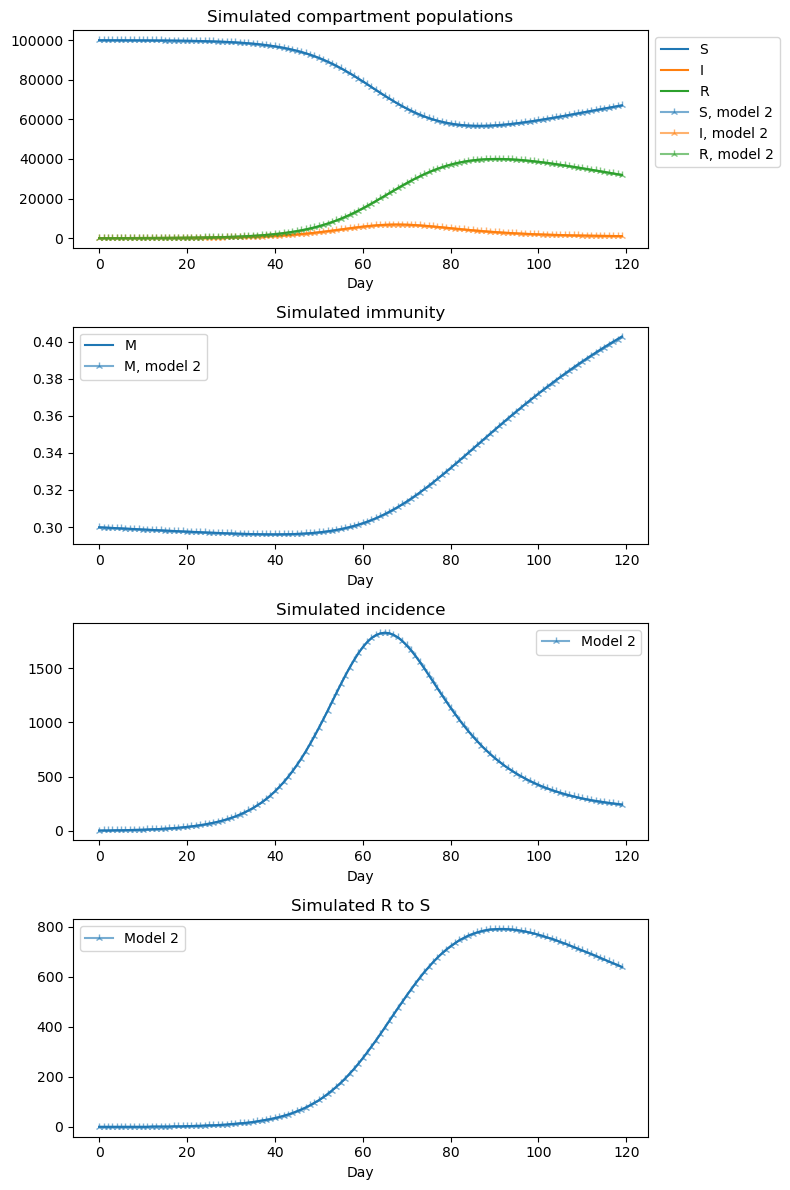

In [7]:
model = imm.ToyImmunitySubpopModel(compartments_epi_metrics_dict,
                                   params_dict,
                                   config_dict,
                                   np.random.Generator(bit_generator))

model.params.immune_gain = 10
model.params.immune_saturation = 100
model.epi_metrics.M.init_val = 0.3

model.simulate_until_day(120)

model2 = imm.ToyImmunitySubpopModel(compartments_epi_metrics_dict,
                                   params_dict,
                                   config_dict,
                                   np.random.Generator(bit_generator))

model2.params.immune_gain = 97.1
model2.params.immune_saturation = 1000
model2.epi_metrics.M.init_val = 0.3

model2.simulate_until_day(120)

pprint(model.params)
pprint(model2.params)

make_pairwise_comparison_graphs(model, model2)

## We cannot separate beta and the risk reduction constant

Let's look at the differential equation for $S(t)$.

$$
\frac{dS}{dt} = \sigma^{R\rightarrow S} R(t) - \frac{\beta I(t)}{N (1 + k M(t))} S(t)
$$

For any combination of $\beta$ and $k$ (suppose we take $\sigma^{R\rightarrow S}$ as given, so we are not fitting it), there are an INFINITE number of pairs $(\tilde{\beta}, \tilde{k})$ that generate the exact same S-I-R-M output!

Proof: the arithmetic is exactly analogous to showing issues with $g$ and $o$. We ultimately get...

$$ \Rightarrow \frac{\beta - \tilde{\beta}}{M(t)} = \tilde{\beta}k - \beta \tilde{k}$$

^ANY pair $(\tilde{\beta}, \tilde{k})$ that satisfies the above equation creates the exact same system as the pair $(\beta, k)$, given that the other parameter values and initial conditions are the same. This is textbook structural non-identifiability.

We'll omit a computational example since this is analogous to the immune gain and immune saturation issue.

## We cannot separate beta and the initial immunity level

Again, let's look at the differential equation for $S(t)$.

$$
\frac{dS}{dt} = \sigma^{R\rightarrow S} R(t) - \frac{\beta I(t)}{N (1 + k M(t))} S(t).
$$

Specifically let's look at the force of infection $$\frac{\beta I(t)}{N (1 + k M(t))} S(t).$$ 

Let's assume $k = 1$ for simplicity, and look at

$$\beta^\prime(t) := \frac{\beta}{(1 + M(t))}.$$

The problem is... we don't observe $M(t)$, and we don't know if our model behavior is due to high $\beta$ and high immunity $M(t)$, or low $\beta$ and low immunity $M(t)$. We can't separate them. 

For example, consider $\beta = 0.5$ and initial immunity level of $M(0) = 0.3$. The "effective beta" at time $0$ is $\beta^\prime(0) = 0.5/1.3$.

$\tilde{\beta} = 0.7307692 \approx (0.5/1.3)*(1.9)$ and $\tilde{M}(0) = 0.9$ have roughly the same effective $\beta$. 

This is not perfect, because unlike the previous two examples with $(g, o)$ and $(\beta, k)$, we don't guarantee the derivative is exactly the same for all time $t$. But using this heuristic, we can get curves that are very similar. See below. See that the curves are almost identical through $120$ days!

Model 1 parameters
ToyImmunitySubpopParams(num_age_groups=1,
                        num_risk_groups=1,
                        total_pop=100000,
                        beta=0.5,
                        I_to_R_rate=0.3,
                        R_to_S_rate=0.02,
                        immune_gain=10,
                        immune_wane=0.0004,
                        immune_saturation=100,
                        risk_reduction=1)


Model 2 parameters
ToyImmunitySubpopParams(num_age_groups=1,
                        num_risk_groups=1,
                        total_pop=100000,
                        beta=0.7307692,
                        I_to_R_rate=0.3,
                        R_to_S_rate=0.02,
                        immune_gain=10,
                        immune_wane=0.0004,
                        immune_saturation=100,
                        risk_reduction=1)


<Figure size 640x480 with 0 Axes>

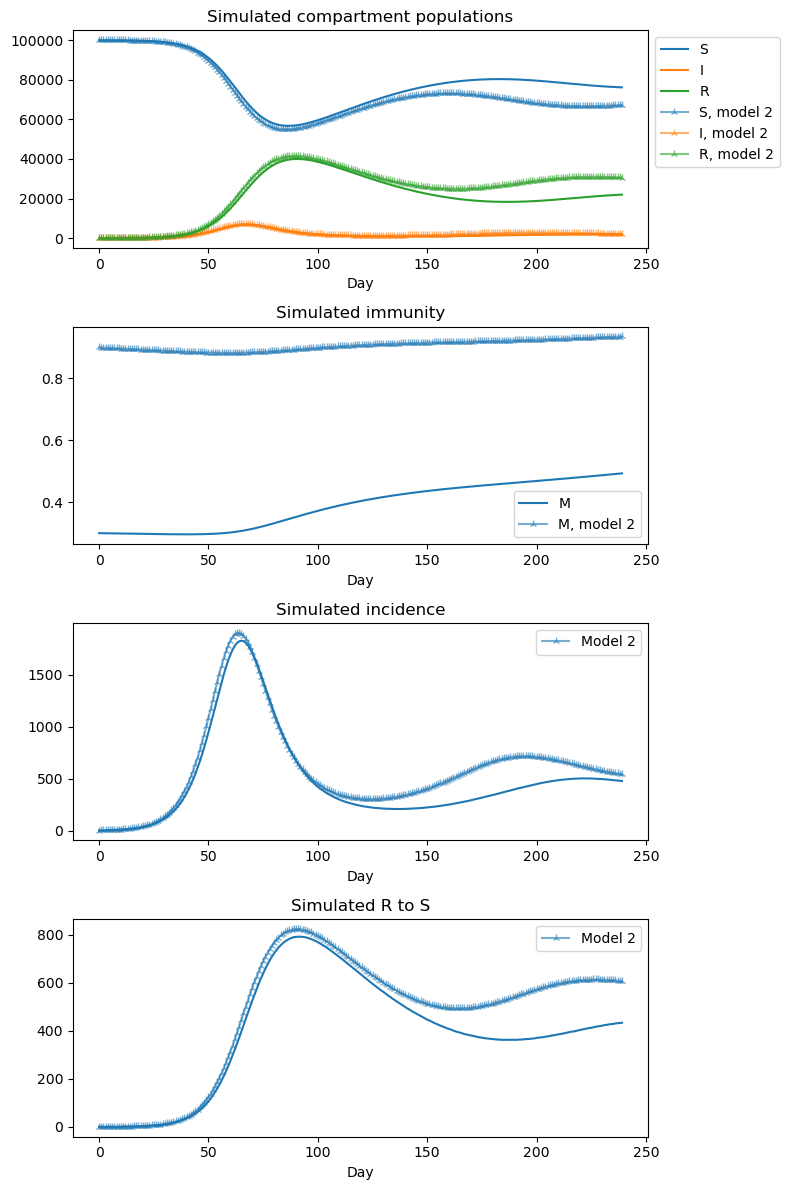

In [8]:
model.reset_simulation()

model.simulate_until_day(240)

model2.reset_simulation()

# Resetting model 2 to have the same immune gain and saturation parameters as model 1
model2.params.immune_gain = 10
model2.params.immune_saturation = 100

model2.params.beta = 0.7307692
model2.epi_metrics.M.init_val = 0.9

model2.simulate_until_day(240)

print("Model 1 parameters")
pprint(model.params)

print("\n")
print("Model 2 parameters")
pprint(model2.params)

make_pairwise_comparison_graphs(model, model2)

## We cannot separate beta and the initial immunity level

The above heuristic was not perfect (not a proof of structural non-identifiability), but see that I can "hand-adjust" other initial values to get essentially an almost perfect fit. I found a pair $(\tilde{\beta}, \tilde{M}(0))$ that gives essentially the exact same output as my other $(\beta, M(0))$. This is textbook practical non-identifiability.

## Is immunity supposed to rise, then fall?

For some sensible parameter values, immunity seems to reach an equilibrium... this actually makes sense because the rate `R_to_S_rate` is very high, so that people leave `R` once every 50 days, roughly. Feel free to play around with different values of parameters. I tested various combinations. 

Model parameters
ToyImmunitySubpopParams(num_age_groups=1,
                        num_risk_groups=1,
                        total_pop=100000,
                        beta=0.5,
                        I_to_R_rate=0.3,
                        R_to_S_rate=0.02,
                        immune_gain=10,
                        immune_wane=0.0004,
                        immune_saturation=100,
                        risk_reduction=1)


<Figure size 640x480 with 0 Axes>

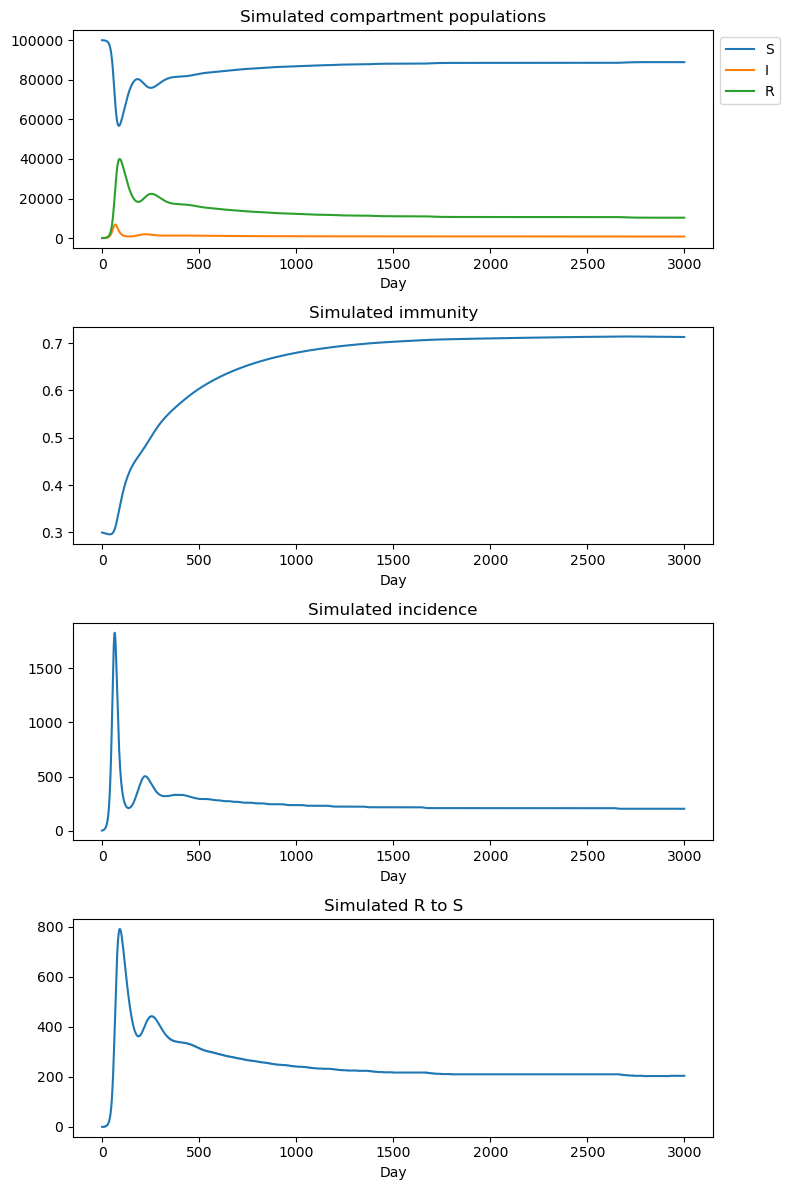

In [9]:
model.reset_simulation()

model.simulate_until_day(3000)

print("Model parameters")
pprint(model.params)

make_graph_set(model)

Model parameters
ToyImmunitySubpopParams(num_age_groups=1,
                        num_risk_groups=1,
                        total_pop=100000,
                        beta=0.5,
                        I_to_R_rate=0.3,
                        R_to_S_rate=0.02,
                        immune_gain=10,
                        immune_wane=0.004,
                        immune_saturation=100,
                        risk_reduction=1)


<Figure size 640x480 with 0 Axes>

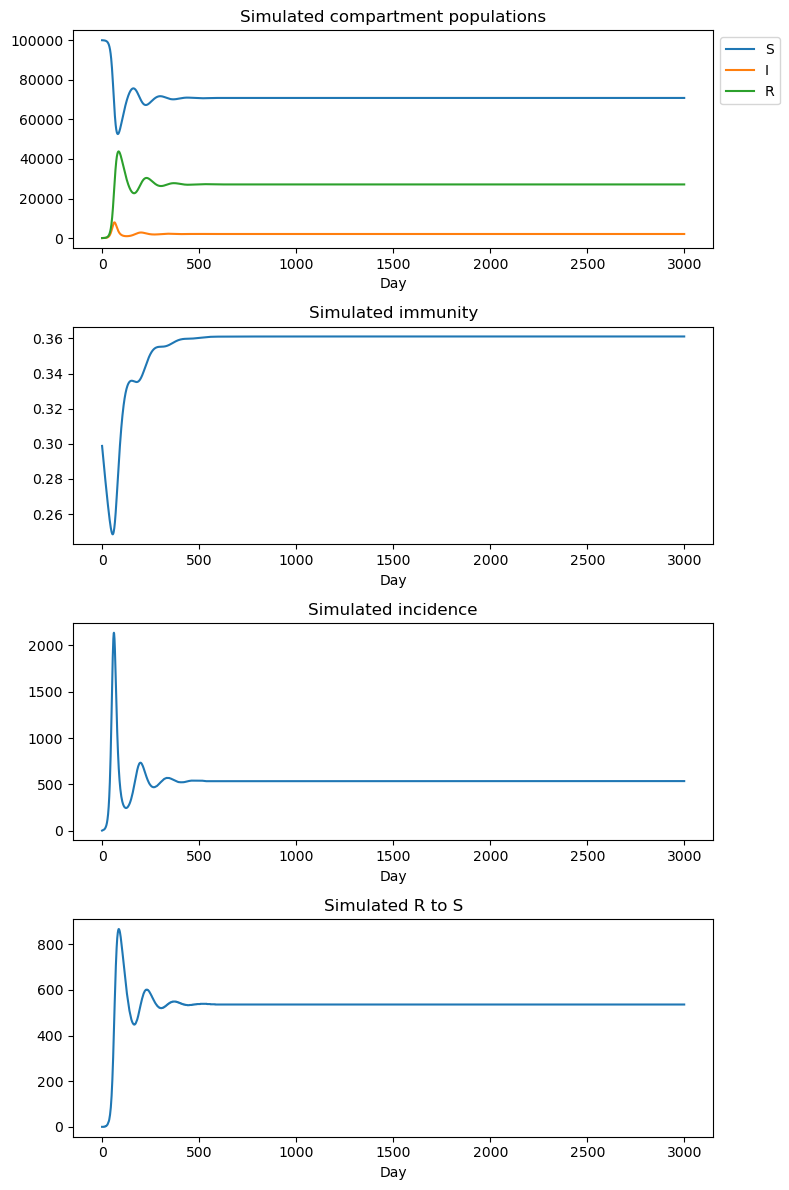

In [10]:
model.reset_simulation()

model.params.immune_gain = 10
model.params.immune_wane = 0.004

model.simulate_until_day(3000)

print("Model parameters")
pprint(model.params)

make_graph_set(model)

## Immunity rising, then falling periodically?

Model parameters
ToyImmunitySubpopParams(num_age_groups=1,
                        num_risk_groups=1,
                        total_pop=100000,
                        beta=0.5,
                        I_to_R_rate=0.3,
                        R_to_S_rate=0.02,
                        immune_gain=10,
                        immune_wane=0.004,
                        immune_saturation=6,
                        risk_reduction=1)


<Figure size 640x480 with 0 Axes>

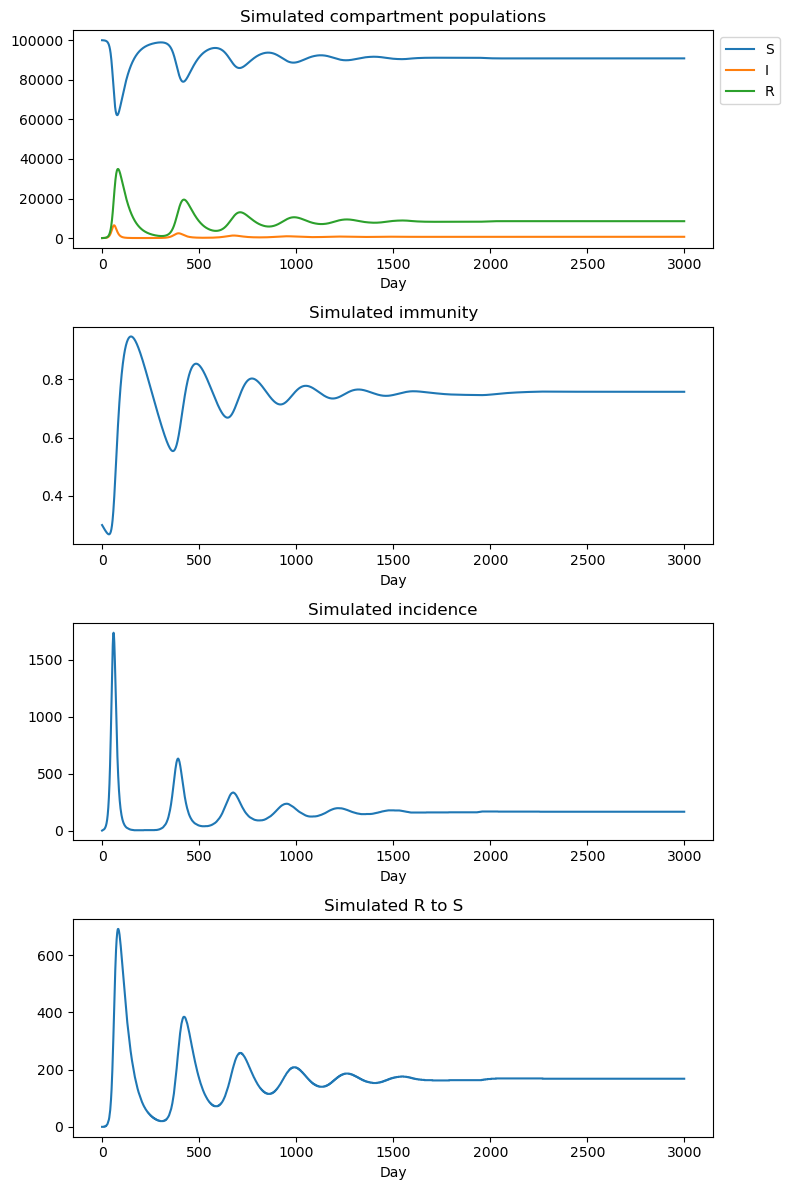

In [11]:
model.reset_simulation()

model.params.immune_gain = 10
model.params.immune_wane = 0.004
model.params.immune_saturation = 6

model.simulate_until_day(3000)

print("Model parameters")
pprint(model.params)

make_graph_set(model)